In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
import sys
sys.path.append('/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection')
from config import system as config_sys
sys.path.append(f'{config_sys.project_code_root}/src')


from helpers import data_bern_numpy_to_preprocessed_hdf5

In [2]:
def iterate_minibatches(data,
                    config,
                    data_augmentation=False,
                    with_labels=False,
                    remove_indices = False,
                    indices_to_remove = [],
                    ):
    '''
    Author: Neerav Kharani, extended by Pol Peiffer
    # Update TODO
    Function to create mini batches from the dataset of a certain batch size
    :param data: numpy dataset
    :param labels: numpy dataset (same as images/volumes)
    :param config: configuration files
    :return: mini batches
    '''

    # ===========================
    # generate indices to randomly select slices in each minibatch
    # ===========================
    if with_labels:
        images = data['images']
        labels = data['masks']

    else:
        images = data
    n_images = images.shape[0]
    if with_labels and remove_indices and len(indices_to_remove) == 2:
        # In the case we use self-supervised learning, we remove some of the images
        # Because they contain the same form of anomalies as the training 
        # We remove the set indices within the list given by user
        random_indices = set(np.arange(n_images))
        indices_to_remove = set(np.arange(indices_to_remove[0], indices_to_remove[1]))
        diff = random_indices - indices_to_remove
        random_indices = np.array(list(diff))
        n_images = n_images - len(indices_to_remove)

        #n_images = n_images - 7*64*3
        
    else:
        random_indices = np.arange(n_images)

    np.random.shuffle(random_indices)

    batch_size = config['batch_size']


    # add a new configuration check
    get_neighbours = config.get('get_neighbours', False)

    # ===========================
    # using only a fraction of the batches in each epoch
    # ===========================
    for b_i in range(0, n_images, batch_size):

        if b_i + batch_size > n_images:
            continue

        # HDF5 requires indices to be in increasing order
        batch_indices = np.sort(random_indices[b_i:b_i+batch_size])

        if get_neighbours:
            extended_batch_indices = []
            for idx in batch_indices:
                patient_num = idx//64
                slice_num = idx % 64
                prev_idx = (patient_num * 64 + max(0, slice_num - 1)) if slice_num != 0 else None
                next_idx = (patient_num * 64 + min(63, slice_num + 1)) if slice_num != 63 else None

                extended_batch_indices.append((images[prev_idx] if prev_idx is not None else np.zeros_like(images[0]),
                                           images[idx], 
                                           images[next_idx] if next_idx is not None else np.zeros_like(images[0])))
        
                
                
            
            X = np.stack([idx_tuple for idx_tuple in extended_batch_indices], axis=0)
            
            if with_labels:
                Y = labels[batch_indices, ...]

        else:
            X = images[batch_indices, ...]
            if with_labels:
                Y = labels[batch_indices, ...]
                
        

        

                                     
        yield (X, Y, batch_indices%config['spatial_size_z']) if with_labels else (X, batch_indices%config['spatial_size_z'])

In [3]:
basepath =  config_sys.project_data_root #"/usr/bmicnas02/data-biwi-01/jeremy_students/data/inselspital/kady"
savepath = config_sys.project_code_root + "data"

In [4]:
data_tr = data_bern_numpy_to_preprocessed_hdf5.load_masked_data(basepath,  0, 5, 'train')
masked_images_train = data_tr['masked_images_train']
masked_images_train.shape

2024-10-08 16:34:38,805 This configuration has not yet been preprocessed.
2024-10-08 16:34:38,806 Preprocessing now...
2024-10-08 16:34:38,810 loading subject 1 out of 5...
2024-10-08 16:34:38,811 patient seg_MACDAVD_113_.npy
--- Logging error ---
Traceback (most recent call last):
  File "/scratch_net/biwidl203/lschlyter/anaconda3/envs/anom/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/scratch_net/biwidl203/lschlyter/anaconda3/envs/anom/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/scratch_net/biwidl203/lschlyter/anaconda3/envs/anom/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/scratch_net/biwidl203/lschlyter/anaconda3/envs/anom/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/scratch_net/biwidl203/lschlyte

(200, 144, 112, 24, 4)

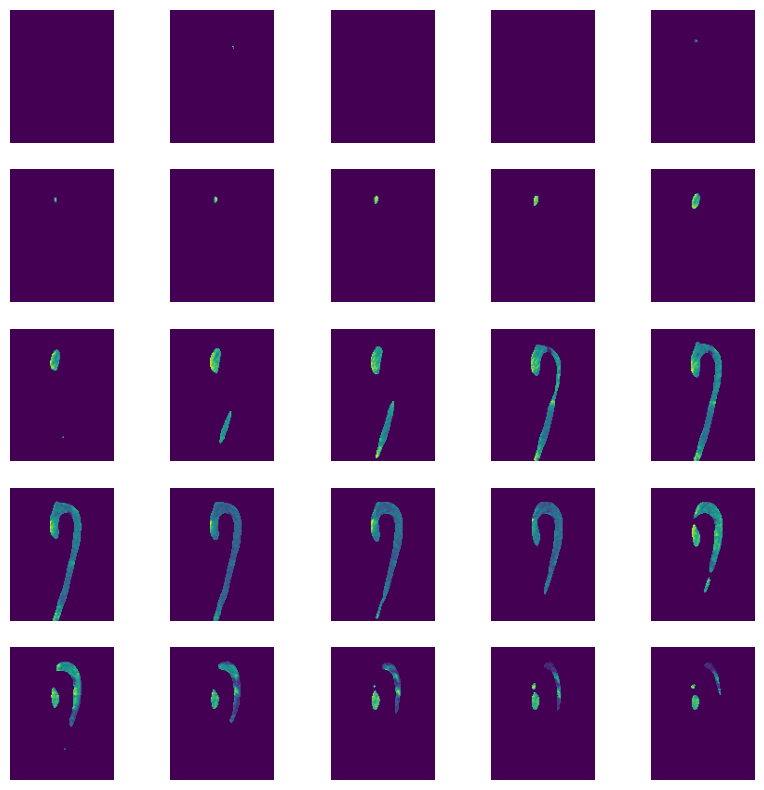

In [5]:

fig, axs = plt.subplots(5,5, figsize=(10,10))
ax = axs.ravel()
for i in range(25):
    ax[i].imshow(masked_images_train[(i+6), :,:, 20,0])
    #ax[i].set_title(i)
    ax[i].axis('off')

In [9]:
data_tr = data_bern_numpy_to_preprocessed_hdf5.load_cropped_data_sliced(basepath, 0, 5, train_test = 'train')
sliced_images_train = data_tr['sliced_images_train']
sliced_images_train.shape

2024-10-08 16:36:11,647 This configuration has not yet been preprocessed.
2024-10-08 16:36:11,649 Preprocessing now...
2024-10-08 16:36:11,656 loading subject 1 out of 5...
2024-10-08 16:36:11,656 patient: seg_MACDAVD_113_.npy
/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/src/helpers/utils.py:355: FutureWarning: `selem` is a deprecated argument name for `binary_erosion`. It will be removed in version 1.0. Please use `footprint` instead.
  avg = binary_erosion(avg, selem=np.ones((erosion_k, erosion_k,erosion_k)))
/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/src/helpers/utils.py:356: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  avg = dilation(avg, selem=np.ones((dilation_k, dilation_k,dilation_k)))
2024-10-08 16:36:22,115 Image shape before cropping and padding:(36, 36, 64, 23, 4)
2024-10-08 16:36:22,125 Image shape after cr

(320, 32, 32, 24, 4)

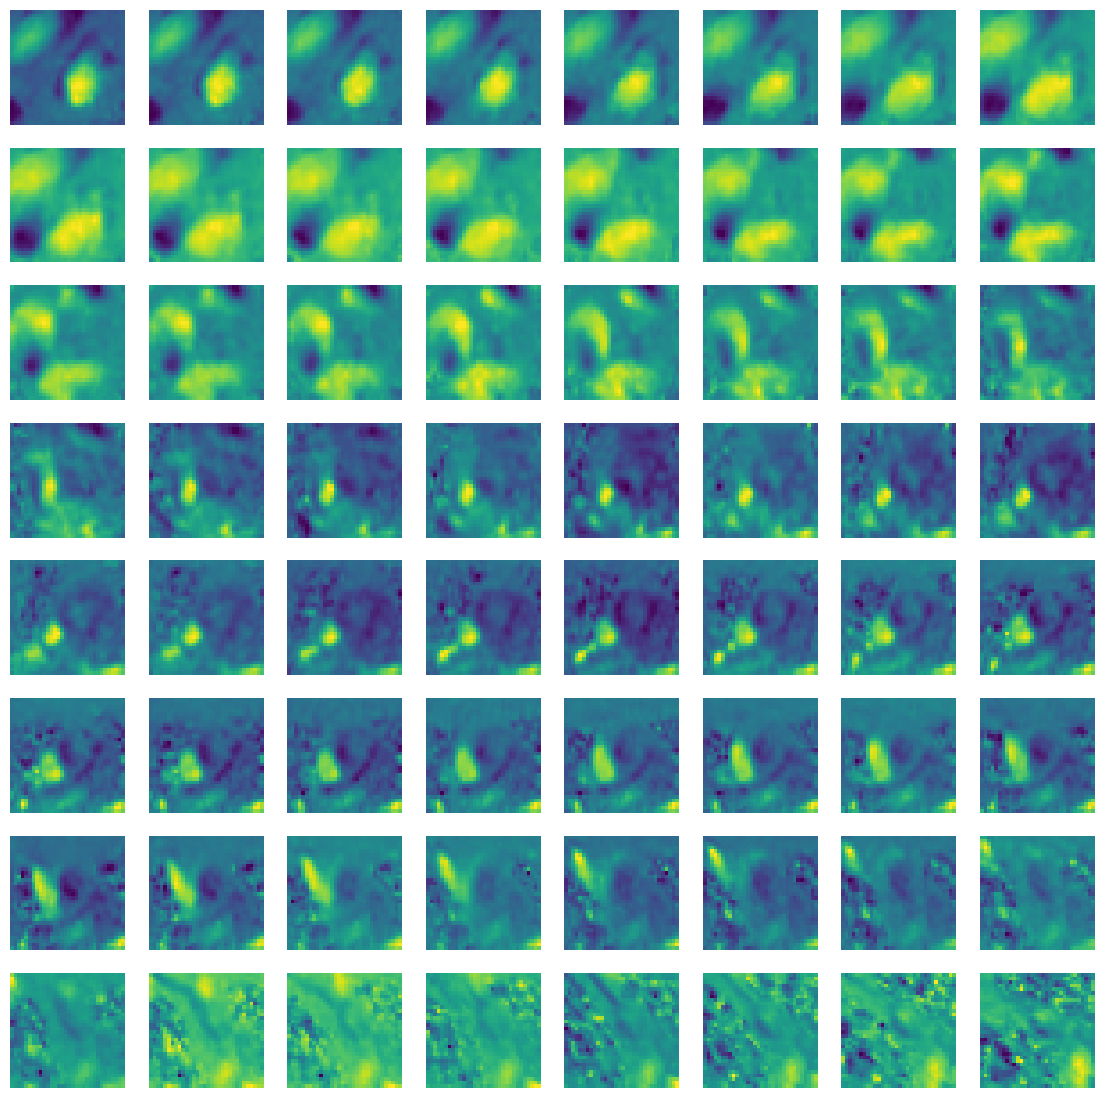

In [10]:
fig, axs = plt.subplots(8,8, figsize=(14,14))
ax = axs.ravel()
for i in range(64):
    ax[i].imshow(sliced_images_train[i+0, :,:,15,1])
    #ax[i].set_title(i)
    ax[i].axis('off')